In [14]:
import sys, os
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.config import PROCESSED_RETURNS_PARQUET


In [16]:
rets = pd.read_parquet(PROCESSED_RETURNS_PARQUET).dropna(how="any")
assets = rets.columns.tolist()

# Baselines
w_base = pd.read_csv("data/processed/baseline_weights.csv", index_col=0)
w_equal = w_base.loc[assets, "Equal Weight"].values
w_mvo   = w_base.loc[assets, "Mean-Variance"].values

# Risk Parity
rp_df = pd.read_csv("data/processed/risk_parity_weights_and_risk.csv", index_col=0)
w_rp = rp_df.loc[assets, "weight"].values

PORTS = {
    "Equal Weight": w_equal,
    "Mean-Variance": w_mvo,
    "Risk Parity": w_rp
}

def port_returns(w):
    return rets @ w


In [17]:
def equity_curve(log_returns: pd.Series) -> pd.Series:
    return np.exp(log_returns.cumsum())

def max_drawdown(log_returns: pd.Series) -> float:
    eq = equity_curve(log_returns)
    peak = eq.cummax()
    dd = eq / peak - 1.0
    return float(dd.min())

def worst_day(log_returns: pd.Series) -> float:
    return float(log_returns.min())

def worst_5days(log_returns: pd.Series) -> float:
    return float(log_returns.nsmallest(5).sum())

def time_to_recover(log_returns: pd.Series) -> int:
    """
    Days to recover from peak-to-trough within the provided window.
    Returns NaN if never recovers to prior peak in that window.
    """
    eq = equity_curve(log_returns)
    peak = eq.cummax()
    dd = eq / peak - 1.0
    trough_date = dd.idxmin()
    peak_before = peak.loc[trough_date]
    after = eq.loc[trough_date:]
    recovered = after[after >= peak_before]
    if recovered.empty:
        return np.nan
    return int((recovered.index[0] - trough_date).days)


In [18]:
STRESS_WINDOWS = {
    "GFC (2008-2009)": ("2008-09-01", "2009-06-30"),
    "COVID Crash (2020)": ("2020-02-15", "2020-04-30"),
    "Inflation/Rate Shock (2022)": ("2022-01-01", "2022-10-31"),
}


In [19]:
rows = []

for label, (start, end) in STRESS_WINDOWS.items():
    window = rets.loc[start:end]
    if window.empty:
        continue

    for pname, w in PORTS.items():
        pr = window @ w

        rows.append({
            "window": label,
            "portfolio": pname,
            "start": window.index.min().date(),
            "end": window.index.max().date(),
            "cum_return": float(np.exp(pr.sum()) - 1),
            "max_drawdown": max_drawdown(pr),
            "worst_day": worst_day(pr),
            "worst_5days": worst_5days(pr),
            "recovery_days_within_window": time_to_recover(pr),
            "ann_vol_in_window": float(pr.std(ddof=1) * np.sqrt(252)),
        })

stress_summary = pd.DataFrame(rows).sort_values(["window","portfolio"])
stress_summary


,window,portfolio,start,end,cum_return,max_drawdown,worst_day,worst_5days,recovery_days_within_window,ann_vol_in_window
0,COVID Crash (2020),Equal Weight,2020-02-18,2020-04-30,-0.105962,-0.297239,-0.105408,-0.362090,NaN,0.557709
1,COVID Crash (2020),Mean-Variance,2020-02-18,2020-04-30,-0.013294,-0.110172,-0.032388,-0.121359,NaN,0.169283
2,COVID Crash (2020),Risk Parity,2020-02-18,2020-04-30,-0.105962,-0.297239,-0.105408,-0.362090,NaN,0.557709
3,Inflation/Rate Shock (2022),Equal Weight,2022-01-03,2022-10-31,-0.153183,-0.206543,-0.036550,-0.166026,NaN,0.193448
4,Inflation/Rate Shock (2022),Mean-Variance,2022-01-03,2022-10-31,-0.114367,-0.134735,-0.019954,-0.066053,NaN,0.085322
5,Inflation/Rate Shock (2022),Risk Parity,2022-01-03,2022-10-31,-0.153183,-0.206543,-0.036550,-0.166026,NaN,0.193448


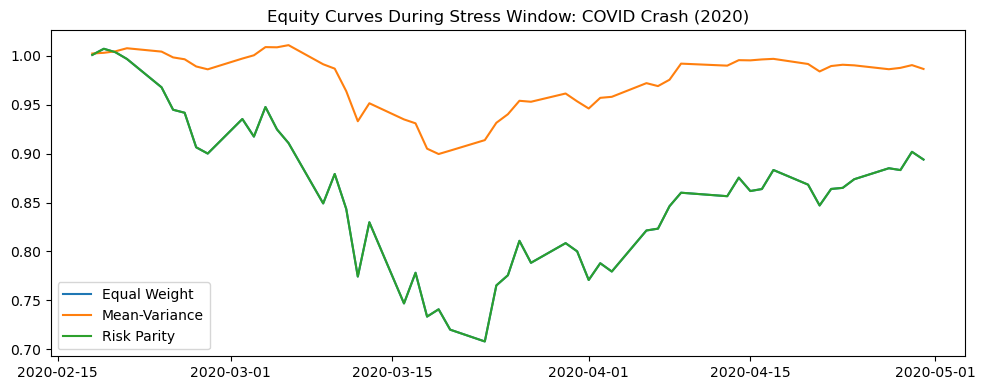

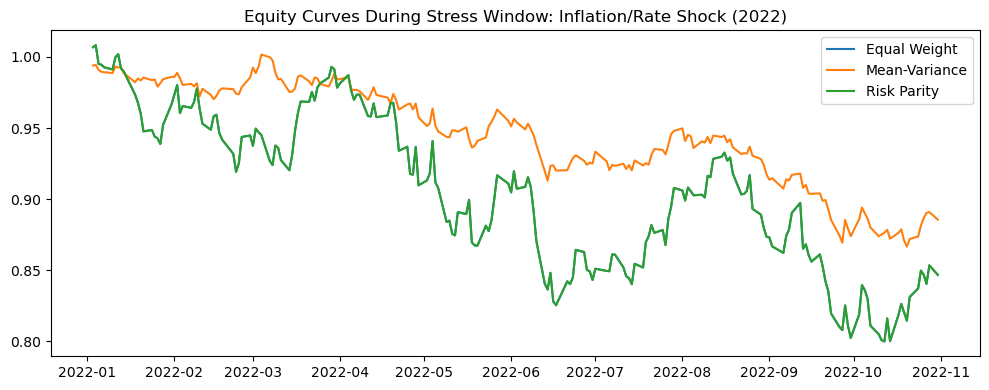

In [20]:
for label, (start, end) in STRESS_WINDOWS.items():
    window = rets.loc[start:end]
    if window.empty:
        continue

    plt.figure(figsize=(10,4))
    for pname, w in PORTS.items():
        pr = window @ w
        plt.plot(equity_curve(pr), label=pname)

    plt.title(f"Equity Curves During Stress Window: {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [21]:
def contribution_table(window_returns: pd.DataFrame, w: np.ndarray, top_n: int = 10):
    # Approx contribution to total log return over the window
    asset_total = window_returns.sum(axis=0).values  # sum of log returns per asset
    contrib = w * asset_total
    out = pd.DataFrame({
        "ticker": window_returns.columns,
        "weight": w,
        "total_log_return_asset": asset_total,
        "contribution_to_port_log_return": contrib
    }).set_index("ticker")
    out["contrib_pct_of_port"] = out["contribution_to_port_log_return"] / out["contribution_to_port_log_return"].sum()
    return out.sort_values("contribution_to_port_log_return").head(top_n)

for label, (start, end) in STRESS_WINDOWS.items():
    window = rets.loc[start:end]
    if window.empty:
        continue

    print("\n" + "="*90)
    print("Stress Window:", label, "|", window.index.min().date(), "to", window.index.max().date())
    for pname, w in PORTS.items():
        print("\n---", pname, "Top Loss Contributors ---")
        display(contribution_table(window, w, top_n=10))



Stress Window: COVID Crash (2020) | 2020-02-18 to 2020-04-30

--- Equal Weight Top Loss Contributors ---


,weight,total_log_return_asset,contribution_to_port_log_return,contrib_pct_of_port
ticker,,,,
BAC,0.022222,-0.364558,-0.008101,0.072328
JPM,0.022222,-0.351150,-0.007803,0.069668
XLE,0.022222,-0.339951,-0.007554,0.067446
XLF,0.022222,-0.304691,-0.006771,0.060451
DBC,0.022222,-0.295678,-0.006571,0.058662
XLI,0.022222,-0.268514,-0.005967,0.053273
XOM,0.022222,-0.266313,-0.005918,0.052836
VNQ,0.022222,-0.260807,-0.005796,0.051744
KO,0.022222,-0.258532,-0.005745,0.051293



--- Mean-Variance Top Loss Contributors ---


,weight,total_log_return_asset,contribution_to_port_log_return,contrib_pct_of_port
ticker,,,,
DBC,0.082413,-0.295678,-0.024368,1.820734
HYG,0.100000,-0.085050,-0.008505,0.635490
KO,0.014504,-0.258532,-0.003750,0.280186
BAC,0.009559,-0.364558,-0.003485,0.260372
JPM,0.006416,-0.351150,-0.002253,0.168335
XLP,0.022116,-0.100525,-0.002223,0.166118
LQD,0.100000,-0.008758,-0.000876,0.065441
BRK-B,0.004495,-0.191037,-0.000859,0.064155
COST,0.006341,-0.047011,-0.000298,0.022275



--- Risk Parity Top Loss Contributors ---


,weight,total_log_return_asset,contribution_to_port_log_return,contrib_pct_of_port
ticker,,,,
BAC,0.022222,-0.364558,-0.008101,0.072328
JPM,0.022222,-0.351150,-0.007803,0.069668
XLE,0.022222,-0.339951,-0.007554,0.067446
XLF,0.022222,-0.304691,-0.006771,0.060451
DBC,0.022222,-0.295678,-0.006571,0.058662
XLI,0.022222,-0.268514,-0.005967,0.053273
XOM,0.022222,-0.266313,-0.005918,0.052836
VNQ,0.022222,-0.260807,-0.005796,0.051744
KO,0.022222,-0.258532,-0.005745,0.051293



Stress Window: Inflation/Rate Shock (2022) | 2022-01-03 to 2022-10-31

--- Equal Weight Top Loss Contributors ---


,weight,total_log_return_asset,contribution_to_port_log_return,contrib_pct_of_port
ticker,,,,
META,0.022222,-1.283834,-0.028530,0.171585
NVDA,0.022222,-0.778222,-0.017294,0.104010
AMZN,0.022222,-0.487020,-0.010823,0.065091
TSLA,0.022222,-0.437044,-0.009712,0.058411
GOOGL,0.022222,-0.427007,-0.009489,0.057070
TLT,0.022222,-0.416988,-0.009266,0.055731
MSFT,0.022222,-0.364253,-0.008095,0.048683
QQQ,0.022222,-0.353682,-0.007860,0.047270
EEM,0.022222,-0.348359,-0.007741,0.046558



--- Mean-Variance Top Loss Contributors ---


,weight,total_log_return_asset,contribution_to_port_log_return,contrib_pct_of_port
ticker,,,,
TLT,0.077719,-0.416988,-0.032408,0.266834
LQD,0.100000,-0.246223,-0.024622,0.202732
IEF,0.100000,-0.184839,-0.018484,0.152191
AGG,0.100000,-0.168145,-0.016815,0.138445
TIP,0.100000,-0.135723,-0.013572,0.111750
HYG,0.100000,-0.132353,-0.013235,0.108975
GLD,0.075438,-0.118141,-0.008912,0.073381
SHY,0.100000,-0.047664,-0.004766,0.039245
PFE,0.010244,-0.214432,-0.002197,0.018087



--- Risk Parity Top Loss Contributors ---


,weight,total_log_return_asset,contribution_to_port_log_return,contrib_pct_of_port
ticker,,,,
META,0.022222,-1.283834,-0.028530,0.171585
NVDA,0.022222,-0.778222,-0.017294,0.104010
AMZN,0.022222,-0.487020,-0.010823,0.065091
TSLA,0.022222,-0.437044,-0.009712,0.058411
GOOGL,0.022222,-0.427007,-0.009489,0.057070
TLT,0.022222,-0.416988,-0.009266,0.055731
MSFT,0.022222,-0.364253,-0.008095,0.048683
QQQ,0.022222,-0.353682,-0.007860,0.047270
EEM,0.022222,-0.348359,-0.007741,0.046558


In [22]:
SCENARIOS = {
    "Rates +200bps (Duration hit)": {
        # proxy: long duration bonds down, equities mildly down
        "TLT": -0.12, "IEF": -0.04, "AGG": -0.03, "SHY": -0.005,
        "SPY": -0.03, "QQQ": -0.04, "IWM": -0.04,
        "HYG": -0.03, "LQD": -0.02,
        "GLD": 0.01
    },
    "Equity -25% Risk-Off": {
        "SPY": -0.25, "QQQ": -0.30, "IWM": -0.28, "DIA": -0.22,
        "EFA": -0.22, "EEM": -0.28,
        "HYG": -0.12, "LQD": -0.06,
        "TLT": 0.08, "IEF": 0.03, "AGG": 0.02,
        "GLD": 0.06
    },
    "Credit Spreads Widen": {
        "HYG": -0.10, "LQD": -0.05, "AGG": -0.01,
        "SPY": -0.08, "QQQ": -0.10,
        "TLT": 0.03, "GLD": 0.03
    }
}


In [23]:
def scenario_vector(assets, scenario_dict):
    # default 0 shock if not specified
    s = pd.Series(0.0, index=assets)
    for k, v in scenario_dict.items():
        if k in s.index:
            s.loc[k] = v
    return s

def simple_to_log(r_simple: pd.Series) -> pd.Series:
    return np.log1p(r_simple)

scenario_rows = []

for sname, shock in SCENARIOS.items():
    svec_simple = scenario_vector(assets, shock)
    svec_log = simple_to_log(svec_simple)

    for pname, w in PORTS.items():
        port_log = float(np.dot(w, svec_log.values))
        port_simple = float(np.expm1(port_log))  # convert back to simple

        # top contributors to loss (approx)
        contrib = w * svec_log.values
        contrib_s = pd.Series(contrib, index=assets).sort_values()

        scenario_rows.append({
            "scenario": sname,
            "portfolio": pname,
            "portfolio_simple_return": port_simple,
            "top_loss_contributors": ", ".join(contrib_s.head(5).index.tolist())
        })

scenario_summary = pd.DataFrame(scenario_rows).sort_values(["scenario","portfolio"])
scenario_summary


,scenario,portfolio,portfolio_simple_return,top_loss_contributors
6,Credit Spreads Widen,Equal Weight,-0.006563,"HYG, QQQ, SPY, LQD, AGG"
7,Credit Spreads Widen,Mean-Variance,-0.012070,"HYG, LQD, AGG, SPY, BRK-B"
8,Credit Spreads Widen,Risk Parity,-0.006563,"HYG, QQQ, SPY, LQD, AGG"
3,Equity -25% Risk-Off,Equal Weight,-0.039283,"QQQ, EEM, IWM, SPY, EFA"
4,Equity -25% Risk-Off,Mean-Variance,-0.003651,"HYG, LQD, SPY, IWM, CVX"
5,Equity -25% Risk-Off,Risk Parity,-0.039283,"QQQ, EEM, IWM, SPY, EFA"
0,Rates +200bps (Duration hit),Equal Weight,-0.007901,"TLT, IWM, IEF, QQQ, AGG"
1,Rates +200bps (Duration hit),Mean-Variance,-0.021642,"TLT, IEF, AGG, HYG, LQD"
2,Rates +200bps (Duration hit),Risk Parity,-0.007901,"TLT, IWM, IEF, QQQ, AGG"


In [24]:
stress_summary.to_csv("data/processed/stress_test_historical_summary.csv", index=False)
scenario_summary.to_csv("data/processed/stress_test_scenario_summary.csv", index=False)

print("Saved: data/processed/stress_test_historical_summary.csv")
print("Saved: data/processed/stress_test_scenario_summary.csv")


Saved: data/processed/stress_test_historical_summary.csv
Saved: data/processed/stress_test_scenario_summary.csv
